In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/polymer')
mask_dir = os.path.join(dataset_dir,'mask/polymer')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/polymer C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/polymer
15761
15761


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


[2025-03-08 22:07:03,554: INFO: 3804955329: date_time: 20250308-220703]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "unet",
    "backbone" : "resnet50", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-03-08 22:07:03,714: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-03-08 22:07:03,714: INFO: 342151172: model_config: {'model_name': 'unet', 'backbone': 'resnet50', 'weights': 'imagenet', 'in_channels': 3}]
[2025-03-08 22:07:03,716: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-03-08 22:07:03,717: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

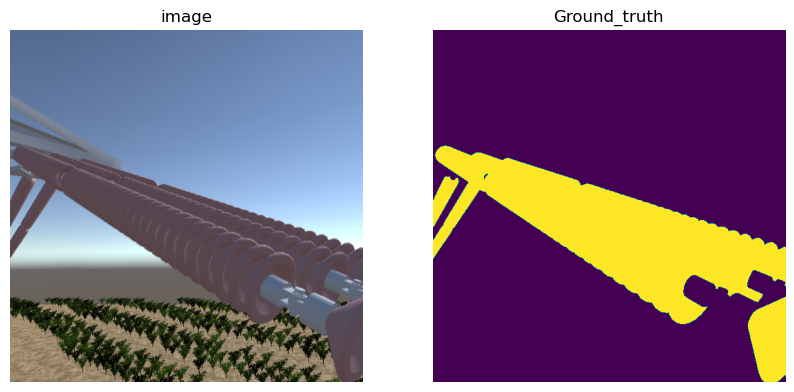

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-03-08 22:07:04,305: INFO: 3993860970: data injection started]
[2025-03-08 22:07:04,312: INFO: 3993860970: train data spliting ]
[2025-03-08 22:07:04,316: INFO: 3993860970: val test spliting ]
[2025-03-08 22:07:04,317: INFO: 3993860970: csv saving started]
[2025-03-08 22:07:04,357: INFO: 3993860970: train csv done ]
[2025-03-08 22:07:04,363: INFO: 3993860970: val csv done ]
[2025-03-08 22:07:04,371: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [09:23<00:00,  3.73it/s, epoch=0, train_loss=0.0215, train_Miou_score=0.484, train_dice_score=0.703, train_acc=0.982, train_binary_jaccard_index=0.875, train_dice_coefficient=0.93] 

[2025-03-08 22:17:18,117: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.02145646097090673]
[2025-03-08 22:17:18,118: INFO: 2273413975: train_loss 0.043185898726252614]
[2025-03-08 22:17:18,119: INFO: 2273413975: train_Miou_score 0.4837283054198343]
[2025-03-08 22:17:18,119: INFO: 2273413975: train_dice_score 0.7032483540524992]
[2025-03-08 22:17:18,120: INFO: 2273413975: train_acc 0.9817388567836028]
[2025-03-08 22:17:18,121: INFO: 2273413975: train_binary_jaccard_index: 0.8752526690160853]
[2025-03-08 22:17:18,122: INFO: 2273413975: train_dice_coefficient: 0.9297283163691181]



100%|██████████| 788/788 [01:07<00:00, 11.69it/s, epoch=0, eval_loss=0.0123, eval_Miou_score=0.499, eval_dice_score=0.762, eval_acc=0.988, eval_binary_jaccard_index=0.913, eval_dice_coefficient=0.95] 

[2025-03-08 22:18:25,511: INFO: 2273413975: Epoch: 0 | Loss: 0.01227290081191184]
[2025-03-08 22:18:25,512: INFO: 2273413975: eval_loss 0.012877362482314851]
[2025-03-08 22:18:25,513: INFO: 2273413975: eval_Miou_score 0.4989438872822196]
[2025-03-08 22:18:25,514: INFO: 2273413975: eval_dice_score 0.7616184451404562]
[2025-03-08 22:18:25,514: INFO: 2273413975: eval_acc 0.9879349621419374]
[2025-03-08 22:18:25,515: INFO: 2273413975: eval_binary_jaccard_index: 0.9130847177983541]
[2025-03-08 22:18:25,516: INFO: 2273413975: eval_dice_coefficient: 0.94978537400022]



100%|██████████| 2102/2102 [07:28<00:00,  4.69it/s, epoch=1, train_loss=0.00926, train_Miou_score=0.498, train_dice_score=0.746, train_acc=0.986, train_binary_jaccard_index=0.904, train_dice_coefficient=0.947]

[2025-03-08 22:25:53,751: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.009257139278297534]
[2025-03-08 22:25:53,751: INFO: 2273413975: train_loss 0.026083913774577205]
[2025-03-08 22:25:53,752: INFO: 2273413975: train_Miou_score 0.4982995295934344]
[2025-03-08 22:25:53,753: INFO: 2273413975: train_dice_score 0.7455391960234499]
[2025-03-08 22:25:53,754: INFO: 2273413975: train_acc 0.9863063061129582]
[2025-03-08 22:25:53,754: INFO: 2273413975: train_binary_jaccard_index: 0.9042642295580325]
[2025-03-08 22:25:53,755: INFO: 2273413975: train_dice_coefficient: 0.9470110058775447]



100%|██████████| 788/788 [00:49<00:00, 16.07it/s, epoch=1, eval_loss=0.0154, eval_Miou_score=0.496, eval_dice_score=0.76, eval_acc=0.987, eval_binary_jaccard_index=0.905, eval_dice_coefficient=0.944] 

[2025-03-08 22:26:42,786: INFO: 2273413975: Epoch: 1 | Loss: 0.01539371030282248]
[2025-03-08 22:26:42,787: INFO: 2273413975: eval_loss 0.01519748847183528]
[2025-03-08 22:26:42,788: INFO: 2273413975: eval_Miou_score 0.4964403656912911]
[2025-03-08 22:26:42,788: INFO: 2273413975: eval_dice_score 0.7596034724265337]
[2025-03-08 22:26:42,789: INFO: 2273413975: eval_acc 0.9866465336175134]
[2025-03-08 22:26:42,789: INFO: 2273413975: eval_binary_jaccard_index: 0.9049103865541782]
[2025-03-08 22:26:42,790: INFO: 2273413975: eval_dice_coefficient: 0.9441870361479922]



100%|██████████| 2102/2102 [07:45<00:00,  4.52it/s, epoch=2, train_loss=0.00822, train_Miou_score=0.505, train_dice_score=0.765, train_acc=0.988, train_binary_jaccard_index=0.917, train_dice_coefficient=0.954]

[2025-03-08 22:34:28,337: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.008224812322974092]
[2025-03-08 22:34:28,338: INFO: 2273413975: train_loss 0.020244927224372038]
[2025-03-08 22:34:28,339: INFO: 2273413975: train_Miou_score 0.5052964265714968]
[2025-03-08 22:34:28,339: INFO: 2273413975: train_dice_score 0.7647088342480647]
[2025-03-08 22:34:28,340: INFO: 2273413975: train_acc 0.9881531906211107]
[2025-03-08 22:34:28,340: INFO: 2273413975: train_binary_jaccard_index: 0.916773503954037]
[2025-03-08 22:34:28,341: INFO: 2273413975: train_dice_coefficient: 0.9543301444495316]



100%|██████████| 788/788 [00:55<00:00, 14.14it/s, epoch=2, eval_loss=0.0107, eval_Miou_score=0.504, eval_dice_score=0.772, eval_acc=0.988, eval_binary_jaccard_index=0.912, eval_dice_coefficient=0.949] 

[2025-03-08 22:35:24,087: INFO: 2273413975: Epoch: 2 | Loss: 0.01072668371164254]
[2025-03-08 22:35:24,088: INFO: 2273413975: eval_loss 0.01334023021685025]
[2025-03-08 22:35:24,089: INFO: 2273413975: eval_Miou_score 0.5042885333136538]
[2025-03-08 22:35:24,090: INFO: 2273413975: eval_dice_score 0.7721535524041369]
[2025-03-08 22:35:24,091: INFO: 2273413975: eval_acc 0.9875410220344659]
[2025-03-08 22:35:24,091: INFO: 2273413975: eval_binary_jaccard_index: 0.9120165997022501]
[2025-03-08 22:35:24,092: INFO: 2273413975: eval_dice_coefficient: 0.9485713206851999]



100%|██████████| 2102/2102 [07:14<00:00,  4.84it/s, epoch=3, train_loss=0.00622, train_Miou_score=0.51, train_dice_score=0.78, train_acc=0.99, train_binary_jaccard_index=0.926, train_dice_coefficient=0.96]    

[2025-03-08 22:42:38,212: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.006216364061117852]
[2025-03-08 22:42:38,213: INFO: 2273413975: train_loss 0.01682341686324015]
[2025-03-08 22:42:38,214: INFO: 2273413975: train_Miou_score 0.5102423393689486]
[2025-03-08 22:42:38,214: INFO: 2273413975: train_dice_score 0.7798757811655582]
[2025-03-08 22:42:38,215: INFO: 2273413975: train_acc 0.9895716983502417]
[2025-03-08 22:42:38,216: INFO: 2273413975: train_binary_jaccard_index: 0.9262648132017377]
[2025-03-08 22:42:38,217: INFO: 2273413975: train_dice_coefficient: 0.9597998229872402]



100%|██████████| 788/788 [00:46<00:00, 17.02it/s, epoch=3, eval_loss=0.0129, eval_Miou_score=0.508, eval_dice_score=0.779, eval_acc=0.987, eval_binary_jaccard_index=0.914, eval_dice_coefficient=0.95] 

[2025-03-08 22:43:24,528: INFO: 2273413975: Epoch: 3 | Loss: 0.012923286045868385]


[2025-03-08 22:43:24,529: INFO: 2273413975: eval_loss 0.013061226203522283]
[2025-03-08 22:43:24,529: INFO: 2273413975: eval_Miou_score 0.5077025273647561]
[2025-03-08 22:43:24,530: INFO: 2273413975: eval_dice_score 0.7787441027984212]
[2025-03-08 22:43:24,531: INFO: 2273413975: eval_acc 0.9874326359802091]
[2025-03-08 22:43:24,531: INFO: 2273413975: eval_binary_jaccard_index: 0.9141306096243526]
[2025-03-08 22:43:24,532: INFO: 2273413975: eval_dice_coefficient: 0.9495491213400913]


100%|██████████| 2102/2102 [07:46<00:00,  4.51it/s, epoch=4, train_loss=0.00584, train_Miou_score=0.513, train_dice_score=0.79, train_acc=0.99, train_binary_jaccard_index=0.932, train_dice_coefficient=0.963] 

[2025-03-08 22:51:10,626: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.005838754883728971]
[2025-03-08 22:51:10,626: INFO: 2273413975: train_loss 0.014636196116249271]
[2025-03-08 22:51:10,627: INFO: 2273413975: train_Miou_score 0.5134382707833336]
[2025-03-08 22:51:10,628: INFO: 2273413975: train_dice_score 0.789871612717207]
[2025-03-08 22:51:10,629: INFO: 2273413975: train_acc 0.9904955823516755]
[2025-03-08 22:51:10,630: INFO: 2273413975: train_binary_jaccard_index: 0.9323364162266424]
[2025-03-08 22:51:10,631: INFO: 2273413975: train_dice_coefficient: 0.9632686484364474]



100%|██████████| 788/788 [00:48<00:00, 16.09it/s, epoch=4, eval_loss=0.00989, eval_Miou_score=0.509, eval_dice_score=0.789, eval_acc=0.988, eval_binary_jaccard_index=0.918, eval_dice_coefficient=0.952]

[2025-03-08 22:51:59,605: INFO: 2273413975: Epoch: 4 | Loss: 0.009890937638766875]
[2025-03-08 22:51:59,605: INFO: 2273413975: eval_loss 0.01222463799055175]
[2025-03-08 22:51:59,606: INFO: 2273413975: eval_Miou_score 0.5094999220338059]
[2025-03-08 22:51:59,607: INFO: 2273413975: eval_dice_score 0.7891684995368501]
[2025-03-08 22:51:59,607: INFO: 2273413975: eval_acc 0.9879725877403608]
[2025-03-08 22:51:59,607: INFO: 2273413975: eval_binary_jaccard_index: 0.9181825269675497]
[2025-03-08 22:51:59,608: INFO: 2273413975: eval_dice_coefficient: 0.9517849440828702]



100%|██████████| 2102/2102 [07:28<00:00,  4.69it/s, epoch=5, train_loss=0.00522, train_Miou_score=0.516, train_dice_score=0.799, train_acc=0.991, train_binary_jaccard_index=0.937, train_dice_coefficient=0.966]

[2025-03-08 22:59:28,170: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.005220904308313647]
[2025-03-08 22:59:28,171: INFO: 2273413975: train_loss 0.01311441988066797]
[2025-03-08 22:59:28,172: INFO: 2273413975: train_Miou_score 0.5159939145554144]
[2025-03-08 22:59:28,172: INFO: 2273413975: train_dice_score 0.7985946722470444]
[2025-03-08 22:59:28,173: INFO: 2273413975: train_acc 0.9912132018810221]
[2025-03-08 22:59:28,174: INFO: 2273413975: train_binary_jaccard_index: 0.9371692693475935]
[2025-03-08 22:59:28,175: INFO: 2273413975: train_dice_coefficient: 0.9660160312313605]



100%|██████████| 788/788 [00:48<00:00, 16.25it/s, epoch=5, eval_loss=0.00677, eval_Miou_score=0.512, eval_dice_score=0.797, eval_acc=0.989, eval_binary_jaccard_index=0.924, eval_dice_coefficient=0.955]

[2025-03-08 23:00:16,672: INFO: 2273413975: Epoch: 5 | Loss: 0.006770598933781464]
[2025-03-08 23:00:16,672: INFO: 2273413975: eval_loss 0.011343772509829882]
[2025-03-08 23:00:16,673: INFO: 2273413975: eval_Miou_score 0.5124053986171456]
[2025-03-08 23:00:16,674: INFO: 2273413975: eval_dice_score 0.7969787395441064]
[2025-03-08 23:00:16,675: INFO: 2273413975: eval_acc 0.9888528526938708]
[2025-03-08 23:00:16,676: INFO: 2273413975: eval_binary_jaccard_index: 0.92382727250419]
[2025-03-08 23:00:16,676: INFO: 2273413975: eval_dice_coefficient: 0.9553269622896066]



100%|██████████| 2102/2102 [07:17<00:00,  4.80it/s, epoch=6, train_loss=0.00464, train_Miou_score=0.518, train_dice_score=0.806, train_acc=0.992, train_binary_jaccard_index=0.941, train_dice_coefficient=0.968]

[2025-03-08 23:07:34,493: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.004639106574906949]
[2025-03-08 23:07:34,493: INFO: 2273413975: train_loss 0.011909829436037243]
[2025-03-08 23:07:34,495: INFO: 2273413975: train_Miou_score 0.5182431948112861]
[2025-03-08 23:07:34,496: INFO: 2273413975: train_dice_score 0.8055337566628685]
[2025-03-08 23:07:34,497: INFO: 2273413975: train_acc 0.9918082513303006]
[2025-03-08 23:07:34,497: INFO: 2273413975: train_binary_jaccard_index: 0.9411377227963014]
[2025-03-08 23:07:34,498: INFO: 2273413975: train_dice_coefficient: 0.9682630223870462]



100%|██████████| 788/788 [00:49<00:00, 16.04it/s, epoch=6, eval_loss=0.0122, eval_Miou_score=0.513, eval_dice_score=0.8, eval_acc=0.989, eval_binary_jaccard_index=0.925, eval_dice_coefficient=0.956]   

[2025-03-08 23:08:23,636: INFO: 2273413975: Epoch: 6 | Loss: 0.01224246197545589]
[2025-03-08 23:08:23,637: INFO: 2273413975: eval_loss 0.011341525662948042]
[2025-03-08 23:08:23,637: INFO: 2273413975: eval_Miou_score 0.5127235252987269]


[2025-03-08 23:08:23,638: INFO: 2273413975: eval_dice_score 0.7997147605414728]
[2025-03-08 23:08:23,639: INFO: 2273413975: eval_acc 0.9886980392173894]
[2025-03-08 23:08:23,640: INFO: 2273413975: eval_binary_jaccard_index: 0.9245842367145919]
[2025-03-08 23:08:23,640: INFO: 2273413975: eval_dice_coefficient: 0.955821745049214]


100%|██████████| 2102/2102 [07:21<00:00,  4.76it/s, epoch=7, train_loss=0.00485, train_Miou_score=0.52, train_dice_score=0.811, train_acc=0.992, train_binary_jaccard_index=0.944, train_dice_coefficient=0.97]  

[2025-03-08 23:15:44,851: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.004848716998531294]
[2025-03-08 23:15:44,852: INFO: 2273413975: train_loss 0.011009380572302704]
[2025-03-08 23:15:44,853: INFO: 2273413975: train_Miou_score 0.5199142448439287]
[2025-03-08 23:15:44,853: INFO: 2273413975: train_dice_score 0.8110170684618384]
[2025-03-08 23:15:44,854: INFO: 2273413975: train_acc 0.9922279812657867]
[2025-03-08 23:15:44,855: INFO: 2273413975: train_binary_jaccard_index: 0.9440230633948286]
[2025-03-08 23:15:44,856: INFO: 2273413975: train_dice_coefficient: 0.9698859599147084]



100%|██████████| 788/788 [00:51<00:00, 15.42it/s, epoch=7, eval_loss=0.0113, eval_Miou_score=0.514, eval_dice_score=0.802, eval_acc=0.989, eval_binary_jaccard_index=0.925, eval_dice_coefficient=0.956] 

[2025-03-08 23:16:35,971: INFO: 2273413975: Epoch: 7 | Loss: 0.011299090639588796]
[2025-03-08 23:16:35,973: INFO: 2273413975: eval_loss 0.011270436894517392]
[2025-03-08 23:16:35,973: INFO: 2273413975: eval_Miou_score 0.5136163417738331]
[2025-03-08 23:16:35,974: INFO: 2273413975: eval_dice_score 0.8015943474344895]
[2025-03-08 23:16:35,975: INFO: 2273413975: eval_acc 0.9887003508316079]
[2025-03-08 23:16:35,975: INFO: 2273413975: eval_binary_jaccard_index: 0.9253015262382057]
[2025-03-08 23:16:35,976: INFO: 2273413975: eval_dice_coefficient: 0.9561572450168634]



100%|██████████| 2102/2102 [07:25<00:00,  4.71it/s, epoch=8, train_loss=0.00405, train_Miou_score=0.521, train_dice_score=0.816, train_acc=0.993, train_binary_jaccard_index=0.947, train_dice_coefficient=0.971]

[2025-03-08 23:24:01,965: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.004051515309726704]
[2025-03-08 23:24:01,966: INFO: 2273413975: train_loss 0.010271740424442309]
[2025-03-08 23:24:01,967: INFO: 2273413975: train_Miou_score 0.5213356493922127]
[2025-03-08 23:24:01,968: INFO: 2273413975: train_dice_score 0.8163664480855405]
[2025-03-08 23:24:01,969: INFO: 2273413975: train_acc 0.9926427982582932]
[2025-03-08 23:24:01,970: INFO: 2273413975: train_binary_jaccard_index: 0.9468633421407352]
[2025-03-08 23:24:01,970: INFO: 2273413975: train_dice_coefficient: 0.9714703368663288]



100%|██████████| 788/788 [00:52<00:00, 14.99it/s, epoch=8, eval_loss=0.00475, eval_Miou_score=0.516, eval_dice_score=0.809, eval_acc=0.989, eval_binary_jaccard_index=0.93, eval_dice_coefficient=0.959] 

[2025-03-08 23:24:54,529: INFO: 2273413975: Epoch: 8 | Loss: 0.004745146798603426]
[2025-03-08 23:24:54,531: INFO: 2273413975: eval_loss 0.010431670452435158]
[2025-03-08 23:24:54,534: INFO: 2273413975: eval_Miou_score 0.5159081612939243]
[2025-03-08 23:24:54,534: INFO: 2273413975: eval_dice_score 0.8087102357191503]
[2025-03-08 23:24:54,536: INFO: 2273413975: eval_acc 0.9894298119391685]
[2025-03-08 23:24:54,538: INFO: 2273413975: eval_binary_jaccard_index: 0.9300654698993215]
[2025-03-08 23:24:54,539: INFO: 2273413975: eval_dice_coefficient: 0.9590150469164289]



100%|██████████| 2102/2102 [07:34<00:00,  4.62it/s, epoch=9, train_loss=0.00397, train_Miou_score=0.523, train_dice_score=0.821, train_acc=0.993, train_binary_jaccard_index=0.949, train_dice_coefficient=0.973]

[2025-03-08 23:32:29,372: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.00396916412036834]
[2025-03-08 23:32:29,373: INFO: 2273413975: train_loss 0.009629153594404565]
[2025-03-08 23:32:29,376: INFO: 2273413975: train_Miou_score 0.5227154519497554]
[2025-03-08 23:32:29,377: INFO: 2273413975: train_dice_score 0.8209445068905118]
[2025-03-08 23:32:29,379: INFO: 2273413975: train_acc 0.9929827566434949]
[2025-03-08 23:32:29,379: INFO: 2273413975: train_binary_jaccard_index: 0.9491742368153058]
[2025-03-08 23:32:29,380: INFO: 2273413975: train_dice_coefficient: 0.9727580837468621]



100%|██████████| 788/788 [00:54<00:00, 14.36it/s, epoch=9, eval_loss=0.0131, eval_Miou_score=0.517, eval_dice_score=0.811, eval_acc=0.989, eval_binary_jaccard_index=0.931, eval_dice_coefficient=0.959]

[2025-03-08 23:33:24,261: INFO: 2273413975: Epoch: 9 | Loss: 0.013071407294515426]
[2025-03-08 23:33:24,262: INFO: 2273413975: eval_loss 0.010860767304615755]
[2025-03-08 23:33:24,263: INFO: 2273413975: eval_Miou_score 0.517386158978505]
[2025-03-08 23:33:24,263: INFO: 2273413975: eval_dice_score 0.8113828175887938]
[2025-03-08 23:33:24,264: INFO: 2273413975: eval_acc 0.9891805622178286]
[2025-03-08 23:33:24,265: INFO: 2273413975: eval_binary_jaccard_index: 0.9309412566349289]
[2025-03-08 23:33:24,265: INFO: 2273413975: eval_dice_coefficient: 0.9594035979660983]



100%|██████████| 2102/2102 [07:51<00:00,  4.45it/s, epoch=10, train_loss=0.00366, train_Miou_score=0.524, train_dice_score=0.825, train_acc=0.993, train_binary_jaccard_index=0.951, train_dice_coefficient=0.974]

[2025-03-08 23:41:16,174: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.003663487512650204]
[2025-03-08 23:41:16,175: INFO: 2273413975: train_loss 0.009084694448142973]
[2025-03-08 23:41:16,176: INFO: 2273413975: train_Miou_score 0.5238798600827346]
[2025-03-08 23:41:16,177: INFO: 2273413975: train_dice_score 0.8252204302980324]
[2025-03-08 23:41:16,178: INFO: 2273413975: train_acc 0.9932886728875603]
[2025-03-08 23:41:16,179: INFO: 2273413975: train_binary_jaccard_index: 0.9512884623148162]
[2025-03-08 23:41:16,180: INFO: 2273413975: train_dice_coefficient: 0.9739381321310219]



100%|██████████| 788/788 [00:52<00:00, 14.92it/s, epoch=10, eval_loss=0.0071, eval_Miou_score=0.518, eval_dice_score=0.815, eval_acc=0.99, eval_binary_jaccard_index=0.933, eval_dice_coefficient=0.961] 

[2025-03-08 23:42:09,006: INFO: 2273413975: Epoch: 10 | Loss: 0.007095711712304711]
[2025-03-08 23:42:09,007: INFO: 2273413975: eval_loss 0.010469884163846858]
[2025-03-08 23:42:09,007: INFO: 2273413975: eval_Miou_score 0.5182560420169418]
[2025-03-08 23:42:09,008: INFO: 2273413975: eval_dice_score 0.8152954645635819]
[2025-03-08 23:42:09,008: INFO: 2273413975: eval_acc 0.9895199600540112]
[2025-03-08 23:42:09,009: INFO: 2273413975: eval_binary_jaccard_index: 0.9326805416984552]
[2025-03-08 23:42:09,010: INFO: 2273413975: eval_dice_coefficient: 0.96050490546375]



100%|██████████| 2102/2102 [07:41<00:00,  4.56it/s, epoch=11, train_loss=0.00345, train_Miou_score=0.525, train_dice_score=0.829, train_acc=0.994, train_binary_jaccard_index=0.953, train_dice_coefficient=0.975]

[2025-03-08 23:49:50,380: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.0034548118781408278]
[2025-03-08 23:49:50,381: INFO: 2273413975: train_loss 0.008616369744483456]
[2025-03-08 23:49:50,383: INFO: 2273413975: train_Miou_score 0.5250034888020648]
[2025-03-08 23:49:50,385: INFO: 2273413975: train_dice_score 0.8292726595261921]
[2025-03-08 23:49:50,386: INFO: 2273413975: train_acc 0.9935608306622603]
[2025-03-08 23:49:50,387: INFO: 2273413975: train_binary_jaccard_index: 0.9531767502305406]
[2025-03-08 23:49:50,388: INFO: 2273413975: train_dice_coefficient: 0.9749861958510908]



100%|██████████| 788/788 [00:53<00:00, 14.72it/s, epoch=11, eval_loss=0.00526, eval_Miou_score=0.519, eval_dice_score=0.82, eval_acc=0.99, eval_binary_jaccard_index=0.935, eval_dice_coefficient=0.962] 

[2025-03-08 23:50:43,926: INFO: 2273413975: Epoch: 11 | Loss: 0.005262845588214506]
[2025-03-08 23:50:43,927: INFO: 2273413975: eval_loss 0.010068560296999199]
[2025-03-08 23:50:43,929: INFO: 2273413975: eval_Miou_score 0.5193372807307318]
[2025-03-08 23:50:43,930: INFO: 2273413975: eval_dice_score 0.8195556254000458]
[2025-03-08 23:50:43,930: INFO: 2273413975: eval_acc 0.9899555162326535]
[2025-03-08 23:50:43,931: INFO: 2273413975: eval_binary_jaccard_index: 0.9351070657240104]
[2025-03-08 23:50:43,932: INFO: 2273413975: eval_dice_coefficient: 0.9620057126633944]



100%|██████████| 2102/2102 [07:40<00:00,  4.56it/s, epoch=12, train_loss=0.00393, train_Miou_score=0.526, train_dice_score=0.832, train_acc=0.994, train_binary_jaccard_index=0.955, train_dice_coefficient=0.976]

[2025-03-08 23:58:24,831: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.003927863007154383]
[2025-03-08 23:58:24,832: INFO: 2273413975: train_loss 0.008283866176239694]
[2025-03-08 23:58:24,834: INFO: 2273413975: train_Miou_score 0.5257289814536127]
[2025-03-08 23:58:24,835: INFO: 2273413975: train_dice_score 0.8322485068629333]
[2025-03-08 23:58:24,836: INFO: 2273413975: train_acc 0.9937546970266152]
[2025-03-08 23:58:24,837: INFO: 2273413975: train_binary_jaccard_index: 0.954507392553379]
[2025-03-08 23:58:24,838: INFO: 2273413975: train_dice_coefficient: 0.9757234215048157]



100%|██████████| 788/788 [00:55<00:00, 14.29it/s, epoch=12, eval_loss=0.00938, eval_Miou_score=0.52, eval_dice_score=0.823, eval_acc=0.99, eval_binary_jaccard_index=0.936, eval_dice_coefficient=0.963] 

[2025-03-08 23:59:19,992: INFO: 2273413975: Epoch: 12 | Loss: 0.009382769238525235]
[2025-03-08 23:59:19,993: INFO: 2273413975: eval_loss 0.010064366605117458]
[2025-03-08 23:59:19,993: INFO: 2273413975: eval_Miou_score 0.520417050651683]
[2025-03-08 23:59:19,994: INFO: 2273413975: eval_dice_score 0.8229147821029503]
[2025-03-08 23:59:19,995: INFO: 2273413975: eval_acc 0.9900069851188258]
[2025-03-08 23:59:19,996: INFO: 2273413975: eval_binary_jaccard_index: 0.9361824422757614]
[2025-03-08 23:59:19,996: INFO: 2273413975: eval_dice_coefficient: 0.9625369940908127]



100%|██████████| 2102/2102 [07:42<00:00,  4.55it/s, epoch=13, train_loss=0.00323, train_Miou_score=0.527, train_dice_score=0.835, train_acc=0.994, train_binary_jaccard_index=0.956, train_dice_coefficient=0.977]

[2025-03-09 00:07:02,156: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.003225918557959211]
[2025-03-09 00:07:02,157: INFO: 2273413975: train_loss 0.007930162619955468]
[2025-03-09 00:07:02,158: INFO: 2273413975: train_Miou_score 0.5266789214424025]
[2025-03-09 00:07:02,159: INFO: 2273413975: train_dice_score 0.8354375666105887]
[2025-03-09 00:07:02,160: INFO: 2273413975: train_acc 0.9939709629509555]
[2025-03-09 00:07:02,161: INFO: 2273413975: train_binary_jaccard_index: 0.9560141017159456]
[2025-03-09 00:07:02,162: INFO: 2273413975: train_dice_coefficient: 0.9765592663909519]



100%|██████████| 788/788 [00:53<00:00, 14.66it/s, epoch=13, eval_loss=0.0099, eval_Miou_score=0.521, eval_dice_score=0.826, eval_acc=0.99, eval_binary_jaccard_index=0.937, eval_dice_coefficient=0.963] 

[2025-03-09 00:07:55,937: INFO: 2273413975: Epoch: 13 | Loss: 0.009898845238734019]
[2025-03-09 00:07:55,938: INFO: 2273413975: eval_loss 0.010091456711471792]
[2025-03-09 00:07:55,939: INFO: 2273413975: eval_Miou_score 0.5212689209487147]
[2025-03-09 00:07:55,941: INFO: 2273413975: eval_dice_score 0.8255586339995884]
[2025-03-09 00:07:55,942: INFO: 2273413975: eval_acc 0.990014172706853]
[2025-03-09 00:07:55,942: INFO: 2273413975: eval_binary_jaccard_index: 0.9369812277311147]
[2025-03-09 00:07:55,943: INFO: 2273413975: eval_dice_coefficient: 0.9628734013664556]



100%|██████████| 2102/2102 [07:42<00:00,  4.55it/s, epoch=14, train_loss=0.0031, train_Miou_score=0.528, train_dice_score=0.839, train_acc=0.994, train_binary_jaccard_index=0.957, train_dice_coefficient=0.977] 

[2025-03-09 00:15:38,432: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.0030958309953945462]
[2025-03-09 00:15:38,433: INFO: 2273413975: train_loss 0.00761127001140963]
[2025-03-09 00:15:38,434: INFO: 2273413975: train_Miou_score 0.5275318145789761]
[2025-03-09 00:15:38,435: INFO: 2273413975: train_dice_score 0.8385589446982353]
[2025-03-09 00:15:38,436: INFO: 2273413975: train_acc 0.994167042941167]
[2025-03-09 00:15:38,437: INFO: 2273413975: train_binary_jaccard_index: 0.9573860864681061]
[2025-03-09 00:15:38,438: INFO: 2273413975: train_dice_coefficient: 0.97731715870992]



100%|██████████| 788/788 [00:55<00:00, 14.12it/s, epoch=14, eval_loss=0.00559, eval_Miou_score=0.522, eval_dice_score=0.829, eval_acc=0.99, eval_binary_jaccard_index=0.939, eval_dice_coefficient=0.964]

[2025-03-09 00:16:34,260: INFO: 2273413975: Epoch: 14 | Loss: 0.00559046214002038]
[2025-03-09 00:16:34,260: INFO: 2273413975: eval_loss 0.009852783365282017]
[2025-03-09 00:16:34,261: INFO: 2273413975: eval_Miou_score 0.5224403145766381]
[2025-03-09 00:16:34,262: INFO: 2273413975: eval_dice_score 0.8288324173245194]


[2025-03-09 00:16:34,263: INFO: 2273413975: eval_acc 0.9903076288058673]
[2025-03-09 00:16:34,264: INFO: 2273413975: eval_binary_jaccard_index: 0.9387859868405737]
[2025-03-09 00:16:34,265: INFO: 2273413975: eval_dice_coefficient: 0.9639483056547475]


100%|██████████| 2102/2102 [07:42<00:00,  4.55it/s, epoch=15, train_loss=0.00297, train_Miou_score=0.528, train_dice_score=0.841, train_acc=0.994, train_binary_jaccard_index=0.959, train_dice_coefficient=0.978]

[2025-03-09 00:24:16,676: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.002972487377961628]
[2025-03-09 00:24:16,677: INFO: 2273413975: train_loss 0.0073151087280597955]
[2025-03-09 00:24:16,679: INFO: 2273413975: train_Miou_score 0.528293827833957]
[2025-03-09 00:24:16,680: INFO: 2273413975: train_dice_score 0.841229215998479]
[2025-03-09 00:24:16,681: INFO: 2273413975: train_acc 0.9943462981710425]
[2025-03-09 00:24:16,682: INFO: 2273413975: train_binary_jaccard_index: 0.958632704103144]
[2025-03-09 00:24:16,683: INFO: 2273413975: train_dice_coefficient: 0.9780053931546039]



100%|██████████| 788/788 [00:54<00:00, 14.37it/s, epoch=15, eval_loss=0.00942, eval_Miou_score=0.523, eval_dice_score=0.831, eval_acc=0.99, eval_binary_jaccard_index=0.94, eval_dice_coefficient=0.964] 

[2025-03-09 00:25:11,519: INFO: 2273413975: Epoch: 15 | Loss: 0.009422814256043603]
[2025-03-09 00:25:11,520: INFO: 2273413975: eval_loss 0.00978374167749728]
[2025-03-09 00:25:11,521: INFO: 2273413975: eval_Miou_score 0.5230512468276225]
[2025-03-09 00:25:11,522: INFO: 2273413975: eval_dice_score 0.8313559850686416]
[2025-03-09 00:25:11,523: INFO: 2273413975: eval_acc 0.9903248681634815]
[2025-03-09 00:25:11,523: INFO: 2273413975: eval_binary_jaccard_index: 0.9397284118033151]
[2025-03-09 00:25:11,524: INFO: 2273413975: eval_dice_coefficient: 0.9644354968598828]



100%|██████████| 2102/2102 [07:43<00:00,  4.54it/s, epoch=16, train_loss=0.00311, train_Miou_score=0.529, train_dice_score=0.844, train_acc=0.994, train_binary_jaccard_index=0.96, train_dice_coefficient=0.979] 

[2025-03-09 00:32:54,735: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.0031069948149226485]
[2025-03-09 00:32:54,737: INFO: 2273413975: train_loss 0.007083665526484924]
[2025-03-09 00:32:54,738: INFO: 2273413975: train_Miou_score 0.5289499625199161]
[2025-03-09 00:32:54,739: INFO: 2273413975: train_dice_score 0.8436425992568599]
[2025-03-09 00:32:54,740: INFO: 2273413975: train_acc 0.994496577191501]
[2025-03-09 00:32:54,740: INFO: 2273413975: train_binary_jaccard_index: 0.959682754890359]
[2025-03-09 00:32:54,741: INFO: 2273413975: train_dice_coefficient: 0.9785828729314782]



100%|██████████| 788/788 [00:54<00:00, 14.49it/s, epoch=16, eval_loss=0.011, eval_Miou_score=0.524, eval_dice_score=0.833, eval_acc=0.99, eval_binary_jaccard_index=0.94, eval_dice_coefficient=0.965]  

[2025-03-09 00:33:49,131: INFO: 2273413975: Epoch: 16 | Loss: 0.011041100179483444]
[2025-03-09 00:33:49,132: INFO: 2273413975: eval_loss 0.009897182543792625]
[2025-03-09 00:33:49,132: INFO: 2273413975: eval_Miou_score 0.5235347510131243]
[2025-03-09 00:33:49,132: INFO: 2273413975: eval_dice_score 0.8334800771831916]
[2025-03-09 00:33:49,134: INFO: 2273413975: eval_acc 0.9902449623795899]
[2025-03-09 00:33:49,135: INFO: 2273413975: eval_binary_jaccard_index: 0.9403841929940162]
[2025-03-09 00:33:49,136: INFO: 2273413975: eval_dice_coefficient: 0.9647418545134491]



100%|██████████| 2102/2102 [07:43<00:00,  4.53it/s, epoch=17, train_loss=0.00316, train_Miou_score=0.53, train_dice_score=0.846, train_acc=0.995, train_binary_jaccard_index=0.961, train_dice_coefficient=0.979] 

[2025-03-09 00:41:32,992: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.003155851142957707]
[2025-03-09 00:41:32,994: INFO: 2273413975: train_loss 0.006850588572792918]
[2025-03-09 00:41:32,995: INFO: 2273413975: train_Miou_score 0.5295238408260736]
[2025-03-09 00:41:32,996: INFO: 2273413975: train_dice_score 0.8458167910296244]
[2025-03-09 00:41:32,997: INFO: 2273413975: train_acc 0.9946273934410772]
[2025-03-09 00:41:32,998: INFO: 2273413975: train_binary_jaccard_index: 0.9605983047814944]
[2025-03-09 00:41:32,999: INFO: 2273413975: train_dice_coefficient: 0.9790852905980583]



100%|██████████| 788/788 [00:54<00:00, 14.41it/s, epoch=17, eval_loss=0.00512, eval_Miou_score=0.524, eval_dice_score=0.835, eval_acc=0.991, eval_binary_jaccard_index=0.942, eval_dice_coefficient=0.966]

[2025-03-09 00:42:27,699: INFO: 2273413975: Epoch: 17 | Loss: 0.005124176592391155]
[2025-03-09 00:42:27,701: INFO: 2273413975: eval_loss 0.009651532719758804]
[2025-03-09 00:42:27,702: INFO: 2273413975: eval_Miou_score 0.5242476018327034]
[2025-03-09 00:42:27,702: INFO: 2273413975: eval_dice_score 0.8353305574470015]
[2025-03-09 00:42:27,703: INFO: 2273413975: eval_acc 0.9905026066592367]
[2025-03-09 00:42:27,704: INFO: 2273413975: eval_binary_jaccard_index: 0.9416562344356783]
[2025-03-09 00:42:27,704: INFO: 2273413975: eval_dice_coefficient: 0.9655632735958466]



100%|██████████| 2102/2102 [07:42<00:00,  4.54it/s, epoch=18, train_loss=0.00287, train_Miou_score=0.53, train_dice_score=0.848, train_acc=0.995, train_binary_jaccard_index=0.962, train_dice_coefficient=0.98] 

[2025-03-09 00:50:10,611: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.002873990163703287]
[2025-03-09 00:50:10,613: INFO: 2273413975: train_loss 0.006636841768226196]
[2025-03-09 00:50:10,615: INFO: 2273413975: train_Miou_score 0.5301445773553882]
[2025-03-09 00:50:10,616: INFO: 2273413975: train_dice_score 0.8480700777682318]
[2025-03-09 00:50:10,616: INFO: 2273413975: train_acc 0.9947592432169164]
[2025-03-09 00:50:10,617: INFO: 2273413975: train_binary_jaccard_index: 0.9615345898861012]
[2025-03-09 00:50:10,618: INFO: 2273413975: train_dice_coefficient: 0.9796010766416855]



100%|██████████| 788/788 [00:55<00:00, 14.26it/s, epoch=18, eval_loss=0.00427, eval_Miou_score=0.525, eval_dice_score=0.839, eval_acc=0.991, eval_binary_jaccard_index=0.943, eval_dice_coefficient=0.967]

[2025-03-09 00:51:05,892: INFO: 2273413975: Epoch: 18 | Loss: 0.004268762499547852]
[2025-03-09 00:51:05,893: INFO: 2273413975: eval_loss 0.009323740413319927]
[2025-03-09 00:51:05,894: INFO: 2273413975: eval_Miou_score 0.5249979000423759]
[2025-03-09 00:51:05,895: INFO: 2273413975: eval_dice_score 0.8385101940146703]
[2025-03-09 00:51:05,896: INFO: 2273413975: eval_acc 0.9907781431262837]
[2025-03-09 00:51:05,896: INFO: 2273413975: eval_binary_jaccard_index: 0.9432414588156411]
[2025-03-09 00:51:05,897: INFO: 2273413975: eval_dice_coefficient: 0.9665460264124673]



100%|██████████| 2102/2102 [07:45<00:00,  4.52it/s, epoch=19, train_loss=0.00283, train_Miou_score=0.531, train_dice_score=0.85, train_acc=0.995, train_binary_jaccard_index=0.962, train_dice_coefficient=0.98] 

[2025-03-09 00:58:51,148: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.002826240519814895]
[2025-03-09 00:58:51,149: INFO: 2273413975: train_loss 0.00644113488199072]
[2025-03-09 00:58:51,150: INFO: 2273413975: train_Miou_score 0.530648870824293]
[2025-03-09 00:58:51,152: INFO: 2273413975: train_dice_score 0.8500732596531213]
[2025-03-09 00:58:51,153: INFO: 2273413975: train_acc 0.9948803009218993]
[2025-03-09 00:58:51,154: INFO: 2273413975: train_binary_jaccard_index: 0.9623763602241151]
[2025-03-09 00:58:51,155: INFO: 2273413975: train_dice_coefficient: 0.9800639013904826]



100%|██████████| 788/788 [00:54<00:00, 14.57it/s, epoch=19, eval_loss=0.00271, eval_Miou_score=0.526, eval_dice_score=0.841, eval_acc=0.991, eval_binary_jaccard_index=0.945, eval_dice_coefficient=0.968]

[2025-03-09 00:59:45,238: INFO: 2273413975: Epoch: 19 | Loss: 0.002712195975526335]
[2025-03-09 00:59:45,239: INFO: 2273413975: eval_loss 0.008999539542668574]
[2025-03-09 00:59:45,240: INFO: 2273413975: eval_Miou_score 0.5257526167952644]
[2025-03-09 00:59:45,241: INFO: 2273413975: eval_dice_score 0.8414390496088211]
[2025-03-09 00:59:45,242: INFO: 2273413975: eval_acc 0.991103934273502]
[2025-03-09 00:59:45,242: INFO: 2273413975: eval_binary_jaccard_index: 0.9449891326112229]
[2025-03-09 00:59:45,243: INFO: 2273413975: eval_dice_coefficient: 0.9676365931702278]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 789/789 [01:20<00:00,  9.80it/s, loss=0.00275, Miou_score=0.55, dice_score=0.9, acc=0.997, binary_jaccard_index=0.978, dice_coefficient=0.988]   

[2025-03-09 01:01:05,756: INFO: 580206084: Test Loss: 0.0027549989021020847]
[2025-03-09 01:01:05,759: INFO: 580206084: Test Miou_score: 0.5504090350654793]
[2025-03-09 01:01:05,761: INFO: 580206084: Test dice_score: 0.8995175057188791]
[2025-03-09 01:01:05,763: INFO: 580206084: Test acc: 0.9972516846747452]
[2025-03-09 01:01:05,764: INFO: 580206084: test_dice_coefficient: 0.988477854029507]
[2025-03-09 01:01:05,765: INFO: 580206084: Test binary_jaccard_index: 0.9783908801840285]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

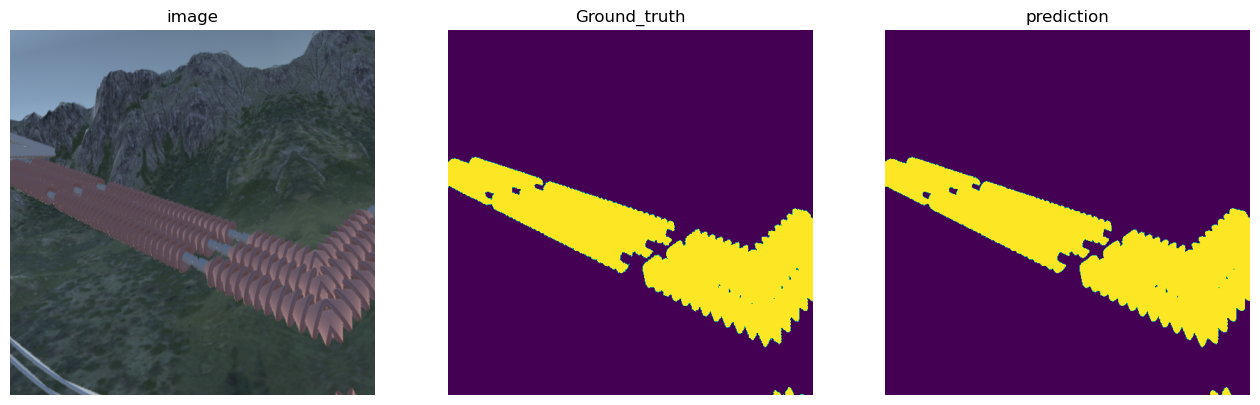

In [22]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [23]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet50_polymer.pth')

In [24]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet50_polymer.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_20972\119622327.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [25]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [26]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [27]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [28]:
real_data = SegmentDataset(dir,2,transform=transform )

In [29]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [30]:
#images, masks = next(iter(real_dataloader))

In [31]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [32]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [33]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [34]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()